<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Model_reactor_1D_steady_state_isothermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reactions

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \end{array}


# LOAD LIBRARIES

In [ ]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import stats

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 200)

In [ ]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.14.0
numpy:1.23.5
pandas:1.5.3


# SETUP

**Indexing in arrays:**

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [ ]:
# @title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

L_R = 0.720               # reactor length [m]
d_R = 0.133               # reactor diameter [m]
r_R = d_R/2               # reactor radius [m]
A_R = np.pi*np.power(r_R, 2, dtype=float)               # reactor crossectional area [a.u.]
V_R = A_R*L_R             # reactor volume [m^3]
m_cat = 15                # catalyst mass [kg]
dens_cat_part = 3.28426*np.power(10, 3, dtype=float)    # catalyst particle density [kg m^-3]
dens_cat = m_cat/V_R      # catalyst density [kg m^-3]
dens_cat_bulk = 0.96*np.power(10, 3, dtype=float)       # catalyst bulk density [kg m^-3]
p_in = 1                  # inlet pressure [bar]
n_Flow_total = 8.36812    # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5           # inlet molefraction methanol
x_H2O_in = 0.5            # inlet molefraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]
m_cat_0 = 0               # starting mass of catalyst [kg] !! typically 0
steps = 100               # number of steps in numerical calculation
dm_cat_model = (m_cat-m_cat_0)/steps                            # finite differential for numerical integration
m_cat_model_span = np.arange(m_cat_0, m_cat + dm_cat_model, dm_cat_model)   # range of mass segments for integration and plotting
R = 8.314                 # universal gas constant [J mol-1 K-1]

# Ergun equation values, partially preliminary
dynvis_gas = np.power(13.3, -3, dtype=float)            # average dynamic viscosity of gas components [Pa s^-1]
D_cat = 1*np.power(10, -3, dtype=float)                    # catalyst particle diameter [m]
eps = 0.4                 # void fraction in packed bed; assumption = spherical & nearly ideally packed
vel_gas = n_Flow_total/(p_in*np.power(10, 5, dtype=float))*R*(150+273)         # gas velocity [m s^-1]
rho_gas = 0.669           # gas density [kg m^-3]

# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
# print(dens_cat)
# print(dens_cat_part)
# print(dens_cat_bulk)

In [ ]:
# @title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

# P0_H2 = 0                     # [bar]
# P0_H2O = p_in*x_MeOH_in       # [bar]
# P0_CO = 0                     # [bar]
# P0_CO2 = 0                    # [bar]
# P0_MeOH = p_in*x_H2O_in       # [bar]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])
# IP = np.array([P0_H2, P0_H2O, P0_CO, P0_CO2, P0_MeOH, m_cat_0])

In [ ]:
# @title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 8.5*np.power(10, -7, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S = 54186              # activation energy [J mol-1]
b_MeOH_MSR_S = 0.570           # rate of reaction exponent for methanol
b_H2O_MSR_S = 0.049           # rate of reaction exponent for water

#reverse MSR reaction

k0_MSR_S_rev = 4.2*np.power(10, -6, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S_rev = 4978                   # activation energy [J mol-1]
b_MeOH_MSR_S_rev = - 0.428            # rate of reaction exponent for methanol
b_H2O_MSR_S_rev = - 0.949             # rate of reaction exponent for water

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_S_rev, EA_MSR_S_rev, b_MeOH_MSR_S_rev, b_H2O_MSR_S_rev]]
)

#MD
k0_MD_S = 1.2*np.power(10, -11, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S = 132540                  # [J mol-1]
b_MeOH_MD_S = 1.114

#reverse MD reaction

k0_MD_S_rev = 5.5*np.power(10, -8, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S_rev = 42137               # [J mol-1]
b_MeOH_MD_S_rev = 0.114

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_S_rev, EA_MD_S_rev, b_MeOH_MD_S_rev]]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


# print(MSR)
# print(MSR[1,1])
#print(ny)

# PFTR ISOTHERMAL AND STEADY STATE

ODE by mass catalyst:

$\frac{d\dot{n_x}}{dm_{cat}}$=$R_x$

In [ ]:
# @title reaction functions

def ReakFun (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[ :-1])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)

  # assigns components to array index for better readability of calculations
  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]


  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)

  # if statement necessary as exponents in reverse reactions are negative -> might divide by zero
  if P_MeOH > 0 and P_H2O > 0:
    revMSR = MSR[1, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMSR *= np.power(P_MeOH, MSR[1, 2], dtype=float)*np.power(P_H2O, MSR[1, 3], dtype=float)*-1
  else:
    revMSR = 0

  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)

  if P_MeOH > 0:
    revMD = MD[1, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[1, 1]/R)*(1/T-1/T0), dtype=float)
    revMD *= np.power(P_MeOH, MD[1, 2], dtype=float)*-1
  else:
      revMD = 0

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])+(revMSR*ny[0, 0] + revMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])+(revMSR*ny[0, 1] + revMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])+(revMSR*ny[0, 2] + revMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])+(revMSR*ny[0, 3] + revMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])+(revMSR*ny[0, 4] + revMD*ny[1, 4])
  dP[5] = 1

  return dP

In [ ]:
# @title reaction functions without reverse reaction

def ReakFunNoReverse (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[ :-1])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)


  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)


  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)


  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1

  return dP

In [ ]:
# @title euler's method

def EulFun (y, T, p_in, m_cat_span, dm_cat, iterations):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(y)])
  ytemp[0,:] = y

  # takes a copy of the last entry in the ytemp results array for the next calculation step
  for i in range(iterations):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    # gets differential from reaction function
    dy = ReakFun(temp, T, p_in)

    # next entry in results array according to euler's method dependant on integration variable dm_cat
    ytemp[i+1, :] = y + dy*dm_cat

    # removes negative entries, might exist due to slope and step size
    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  return ytemp

In [ ]:
# @title euler's method no reverse

def EulFunNoReverse (y, T, p_in, m_cat_span, dm_cat, iterations):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(IC)])
  ytemp[0,:] = y

  for i in range(iterations):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    dy = ReakFunNoReverse(y, T, p_in)

    ytemp[i+1, :] = temp + dy*dm_cat

    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp

In [ ]:
# @title deactivation progression

def DeacFun(t):
  '''
  uses a deactivation function to calculate the change in catalytic efficiency given a time array
  '''
  # the calculation is preliminary and will be corrected later with respect to the present pressure
  # just to test if deactivation function works and can be implemented
  eff_0 = 1
  t_0 = t[0]
  degradation = 0.987 #[h^-1]
  catalyst_efficiency = degradation**t*eff_0

  for i in range (len(t)):
    if catalyst_efficiency [i] < 0:
      catalyst_efficiency [i] = 0
  return catalyst_efficiency

# MAIN

In [ ]:
# @title Main calculation, pressure result

def MainCalcPressure (y, T, p_in, m_cat_span, dm_cat, iterations, rev):


  if rev == 1:
    temp_solution = EulFunNoReverse(y, T, p_in, m_cat_span, dm_cat, iterations)
  else:
    temp_solution = EulFun(y, T, p_in, m_cat_span, dm_cat, iterations)

  # turns molar flowrates into pressures, for every entry except mass catalyst
  for l in range(iterations+1):
    n_ges = np.sum(temp_solution[l, :-1])
    for j in range(5):
      temp_solution[l, j] = temp_solution[l, j]/n_ges*p_in

  return temp_solution

In [ ]:
# @title Main calculation, molar flowrate result

def MainCalcMolFlow (y, T, p_in, m_cat_span, dm_cat, iterations, rev):

  if rev == 1:
    temp_solution = EulFunNoReverse(y, T, p_in, m_cat_span, dm_cat, iterations)
  else:
    temp_solution = EulFun(y, T, p_in, m_cat_span, dm_cat, iterations)

  return temp_solution

In [ ]:
'''
contains main function to call all other relevant functions and set temperature and reaction index
'''
# set reaction temperature and calculate respective volumetric flowrate

T = 273 + 150                                                                 # reactor temperature [K]
VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))              # volumetric flowrate [m^3 h^-1]

# calculates a concentration array using euler's method, with the length Vspan for plotting

pEul = MainCalcPressure(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 0)

pEulNoReverse = MainCalcPressure(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 1)

### testing ###

# pEul2 = MainCalcMolFlow(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 0)

# pEul2frac = pEul2.copy()
# n_ges_pEul2 = np.zeros(len(pEul2frac))
# n_ges_pEul2[:] = np.sum(pEul2frac[:, :-1], 1)
# for i in range(len(pEul2frac)):
#   pEul2frac[i, :-1] = pEul2frac[i, :-1]/n_ges_pEul2[i]

In [ ]:
'''
Creates a new results data set to manipulate. Turns Pressures to molar fractions
'''
# uses ideal gas equation
# archaic calculation; if reactor is isobaric -> molar fraction ~ pressure
# necessary if p != constant or p != 1 bar
# simplified calculation

pEulfrac = pEul.copy()
pEulfrac[:, :-1] = pEulfrac[:, :-1]/p_in


# PRODUCTION CALCULATIONS || Preliminary

In [ ]:
 # @title production total
'''
current model calculates production over mass cat inside the reactor;
this function takes the outcome of the model at the exit (last array entry) and expands it to longer timeframes;
can apply deactivation function to predict production of hydrogen over longer timeframes, given different reactor setups
'''
# define all variables for calculation
n_flow_H2_max = pEul[-1,0]        # molar flowrate at reactor exit [kmol h^-1]
production_time_0 = 0.0           # start of timeframe to examine; must not start at 0 [h]
production_time_max = 40.0        # end of timeframe to examine; [h]
production_steps = 1000           # resolution of calculation
production_stepsize = (production_time_max-production_time_0)/production_steps                  # delta steps [h]
production_time = np.linspace(production_time_0, production_time_max, num=production_steps)     # time array to calculate and plot data, contains time points [h]
catalytic_efficiency = DeacFun(production_time)                 # uses DeacFun to calculate the catalytic efficiency (0 ... 1) for every point in the given time array
production_total = np.zeros(len(production_time))               # total production over the given timeframe, creates empty array
production_hourly = catalytic_efficiency*n_flow_H2_max          # production of hydrogen at each point in time with respect to the deactivation of catalyst over time [kmol]

# sums current production of hydrogen [kmol] to previous steps
# perhaps a futile calculation, but might be used to predict catalytic breakpoints in efficiency
for i in range (len(production_time)-1):
  production_total [i+1] = catalytic_efficiency[i+1]*production_stepsize*n_flow_H2_max + production_total[i]

# MAIN PLOTS

Text(0, 0.5, 'molar fraction')

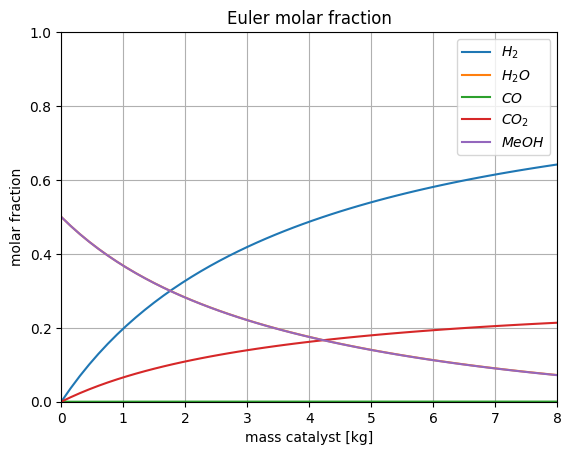

In [ ]:
# @title full plot

'''
plots both reactors in the cascade using euler's method and the runge kutta method
'''
# # at p = 1 bar, the pressure and molar fraction are identical, might uncomment when looking at different pressures
# plt.figure(1)
# plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
# plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
# plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
# plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
# plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
# plt.title("Euler pressure")
# plt.axis((0, 8, 0, 1))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("mass catalyst [kg]")
# plt.ylabel ("pressure [bar]")

plt.figure(2)
plt.plot(pEulfrac[:,5], pEulfrac[:,0], label='$H_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,1], label='$H_2O$')
plt.plot(pEulfrac[:,5], pEulfrac[:,2], label='$CO$')
plt.plot(pEulfrac[:,5], pEulfrac[:,3], label='$CO_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,4], label='$MeOH$')
plt.title("Euler molar fraction")
plt.axis((0, 8, 0, 1))
plt.legend(loc='best')
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("molar fraction")

Text(0, 0.5, 'methanol conversion [%]')

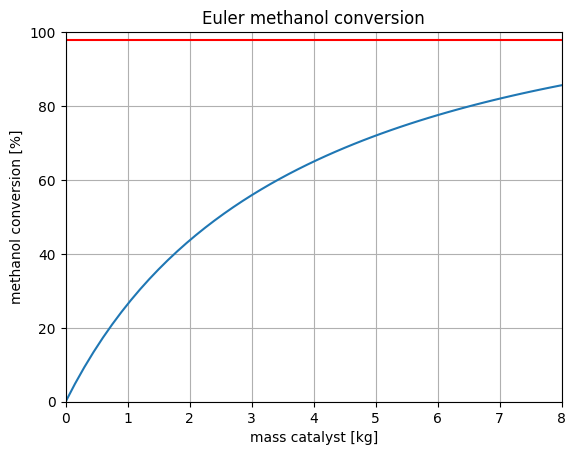

In [ ]:
# @title methanol conversion
'''
used to calculate the conversion of methanol
'''
# copy to not change original array
EulFracX = pEulfrac.copy()
EulFracX = np.delete(EulFracX, [0, 1, 2, 3], 1)

# X = 1-n/n0
EulFracX[:, 0] = (1-EulFracX[:, 0]/EulFracX[0, 0])*100

# plots results and adds horizontal line at X = 98%
plt.figure(1)
plt.plot(EulFracX[:, 1], EulFracX[:, 0], label='$MeOH$')
plt.axhline(y=98, color='r')
plt.title("Euler methanol conversion")
plt.axis((0, 8, 0, 100))
#plt.legend(loc='best')
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("methanol conversion [%]")

# pEulfracX[:,5] = pEulfracX[:,5] * dens_cat * A_R

# plt.figure(2)
# plt.plot(pEulfracX[:,5], pEulfracX[:,4], label='$MeOH$')
# plt.title("Euler methanol conversion")
# plt.axis((16.6, 16.7, 97, 100))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("mass catalyst [kg]")
# plt.ylabel ("methanol conversion [%]")

Text(0, 0.5, 'pressure [bar]')

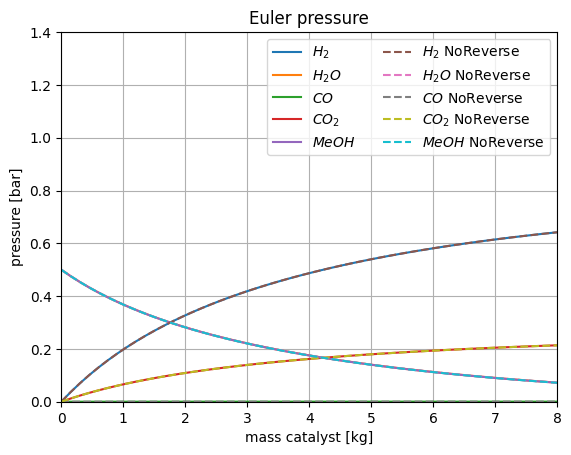

In [ ]:
# @title no reverse reaction comparison
'''
plots results of euler with and without reverse reaction
'''
plt.figure(1)
plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,0], label='$H_2$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,1], label='$H_2O$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,2], label='$CO$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,3], label='$CO_2$ NoReverse', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,4], label='$MeOH$ NoReverse', linestyle='--')
plt.title("Euler pressure")
plt.axis((0, 8, 0, 1.40))
plt.legend(loc='best', ncol=2)
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("pressure [bar]")

Text(0, 0.5, 'difference [%]')

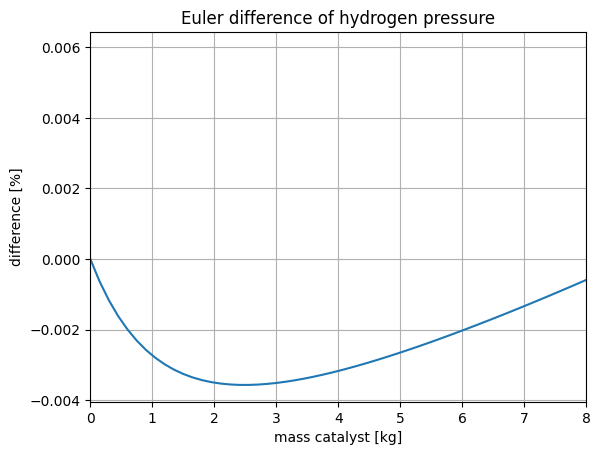

In [ ]:
# @title hydrogen difference no reverse reaction
'''
calculates the difference of resulting pressure along the reactor axis between both reactions and omitting the reverse reaction in %
'''
# difference in %
difference = (pEul[:,0]-pEulNoReverse[:,0])*100

# plots difference
plt.figure(1)
plt.plot(pEul[:,5], difference)
plt.title("Euler difference of hydrogen pressure")
plt.xlim(0, 8)
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("difference [%]")

# PRODUCTION PLOTS || Preliminary

Text(0, 0.5, 'hydrogen production [kmol]')

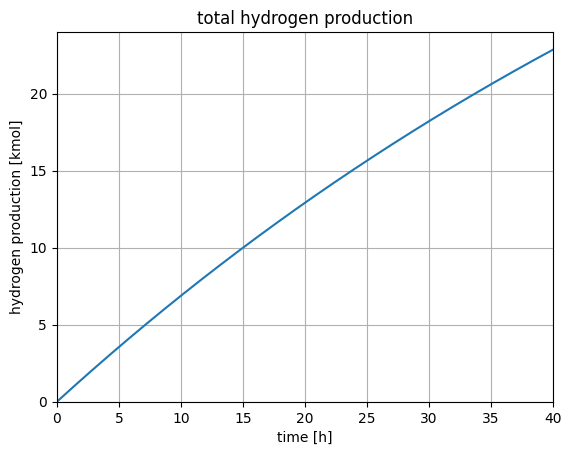

In [ ]:
 # @title total hydrogen production plot
'''
plots total hydrogen production over time
data includes deactivation
'''
plt.figure(1)
plt.plot(production_time, production_total)
plt.title("total hydrogen production")
plt.xlim(production_time_0, production_time_max)
plt.ylim(bottom = production_time_0)
plt.grid()
plt.xlabel("time [h]")
plt.ylabel ("hydrogen production [kmol]")

Text(0, 0.5, 'hydrogen production [kmol]')

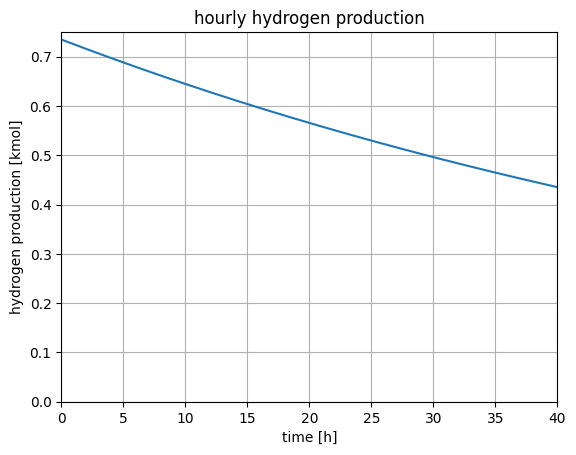

In [ ]:
# @title hourly hydrogen production
'''
plots hourly hydrogen production
shows deactivation
'''
plt.figure(1)
plt.plot(production_time, production_hourly)
plt.title("hourly hydrogen production")
plt.xlim(production_time_0, production_time_max)
plt.ylim(bottom = production_time_0)
plt.grid()
plt.xlabel("time [h]")
plt.ylabel ("hydrogen production [kmol]")

# MAIN ASPEN COMPARISONS

In [ ]:
# # @title comparative aspen arrays

# '''
# contains main function to call all other relevant functions, set comperative temperature/reaction data and create comperative aspen results arrays
# '''
# # extracts excel file from google drive, using pandas library
# xl = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Results 720mm reactor by temp.xlsx')

# # set temperature iterations and results array according to the makeup of the excel file
# AspenPoints = len(xl.sheet_names)
# AspenResults = np.zeros([AspenPoints, 11, len(IC)])
# sheets = xl.sheet_names

# # extract temperature step and boundaries according to excel file
# AspenStartingTemp = int(''.join(filter(str.isdigit, sheets[0])))
# AspenSecondTemp = int(''.join(filter(str.isdigit, sheets[1])))
# AspenEndTemp = int(''.join(filter(str.isdigit, sheets[-1])))
# diff = AspenSecondTemp - AspenStartingTemp

# # sets stepsize specific to aspen
# steps_Aspen = 100

# # set aspen specific reactor data
# L_R_Aspen = 0.720
# d_R_Aspen = 0.133
# r_R_Aspen = d_R_Aspen/2
# A_R_Aspen = np.pi*np.power(r_R_Aspen, 2, dtype=float)
# V_R_Aspen = A_R_Aspen*L_R_Aspen

# # set aspen specific catalyst data, create differention variable and size
# m_cat_Aspen = 7.95
# m_cat_0_Aspen = 0
# dm_cat_Aspen = (m_cat_Aspen-m_cat_0_Aspen)/steps_Aspen
# m_cat_span_Aspen = np.arange(m_cat_0_Aspen, m_cat_Aspen + dm_cat_Aspen, dm_cat_Aspen)
# dens_cat_Aspen = m_cat_Aspen/V_R_Aspen

# # set boundaries according to aspen excel file
# T_min = AspenStartingTemp + 273                                              # minimum temperature boundary [K]
# T_max = AspenEndTemp + 273                                                   # maximum temperature boundary [K]
# T_stepsize = diff                                                            # temperature change per loop iteration [K]

# temperature_arr = np.arange(0, AspenPoints)*T_stepsize + T_min               # sets temperature array to be examined
# pEulTemps = np.zeros([AspenPoints, len(m_cat_span_Aspen), len(IC)])          # setup of results array

# # turns the results in the aspen excel file into arrays, rearranges results columns to mirror model array setup
# for i in range(AspenPoints):
#   df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Results 720mm reactor by temp.xlsx', i)

#   df = df[['H2', 'H2O', 'CO', 'CO2', 'MEOH-1', 'Length']]
#   tempres = df.to_numpy()
#   res = np.delete(tempres, (0), axis=0)
#   AspenResults [i, :, :] = res

# # calls euler function and writes results to master 3D array
# for i in range (AspenPoints):
#   T = temperature_arr [i]                                                 # reactor temperature [K]
#   VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))        # volumetric flowrate [m^3 h^-1]
#   pEulTemps [i, :, :] = EulFun(IC, T, p_in, m_cat_span_Aspen, dm_cat_Aspen, steps_Aspen)
#   pEulTemps [i, :, 5] = pEulTemps [i, :, 5] / dens_cat_Aspen / A_R_Aspen

# # turns pressure to molar fraction
# pEulTemps[:, :-1] = pEulTemps[:, :-1]/p_in

In [ ]:
# # @title transform results to aspen
# '''
# used to transform the aspen results array into excel file and save to google drive
# redo if comparison changes
# '''

# writer = pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/aspen model comparisons.xlsx')

# for i in range(AspenPoints):
#     df = pd.DataFrame(pEulTemps[i, :, :])
#     tempname = i*diff + AspenStartingTemp
#     df.columns = ['H2', 'H2O', 'CO', 'CO2', 'MEOH-1', 'Mass catalyst']
#     df.to_excel(writer, sheet_name = 'T = '+ str(tempname))

# df
# writer.save()


In [ ]:
# @title Ergun

def Ergun (p, L):
  '''
  ergun's equation
  '''
  p = p*np.power(10, 5, dtype=float)

  dp = 150*dynvis_gas*L_R/np.power(D_cat, 2, dtype=float)*np.power((1-eps), 2, dtype=float)/np.power(eps, 3, dtype=float)*vel_gas
  + (1.75*L_R*rho_gas)/D_cat*1-eps/np.power(eps, 3, dtype=float)*vel_gas


  p_neu = p - dp
  p_neu = p_neu/np.power(10, 5, dtype=float)
  return p_neu, dp

# EXPERIMENTAL DATA 72_02

# EXPERIMENTAL DATA 72_02_restart

In [ ]:
# @title experimental data extraction | simple | for now

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_restart_72 = 0.0023 #[lN h^-1]
n_in_restart_72 = 0.08/1000 #[kmol h^-1]


filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/CS_72_02_restart.xlsx'
restart_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse', usecols='B:E, G:I', header = 5)
restart_72 = restart_72.dropna(how='all')
units = restart_72.head(1)
restart_72 = restart_72.drop(0, axis=0)
restart_72_cat = pd.read_excel(filepath, sheet_name ='Ergebnisse')
cat_mass_restart_72 = restart_72_cat.head(2)['Katalysator']
cat_mass_restart_72 = cat_mass_restart_72[1]/1000
restart_72['group']= (restart_72['Reactor Pressure'].diff()> 0.1).cumsum()
restart_72_molar_fraction_base = restart_72['COppm'] + restart_72['CO2'] + restart_72['H2']
restart_72['CO Flow'] = restart_72['COppm']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['CO2 Flow'] = restart_72['CO2']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['H2 Flow'] = restart_72['H2']/restart_72_molar_fraction_base*restart_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
restart_72['H2:CO2 ratio'] = restart_72['H2 Flow']/restart_72['CO2 Flow']
restart_72['X_{MeOH} [%]'] = (1 - ((n_in_restart_72/2)*1000-(restart_72['CO2 Flow']+restart_72['CO Flow']))/((n_in_restart_72*1000)/2))*100

criteria = restart_72.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
restart_72_means = restart_72[criteria].groupby('group').mean()
# restart_72_means['n. MeOH in'] = n_in_restart_72/2*1000
# restart_72_means['X_{MeOH} [%]2'] = (1 - (restart_72_means['n. MeOH in']-restart_72_means['CO2 Flow']-restart_72_means['CO Flow'])/restart_72_means['n. MeOH in'])*100

#*((restart_72['Reactor Temperature']+273)/273))
# @title misc calcs

m_cat_restart_72_span = np.arange(0, cat_mass_restart_72 + cat_mass_restart_72/steps, cat_mass_restart_72/steps)
restart_72_means_array = restart_72_means.to_numpy()
dm_cat_mass_restart_72 = cat_mass_restart_72/steps
compEul_restart_72 = np.zeros([len(restart_72_means_array), len(m_cat_restart_72_span), len(IC)])

IC_restart_72 = np.array([0, n_in_restart_72/2, 0, 0, n_in_restart_72/2, 0])
prodFlow_restart_72_model = np.zeros([len(restart_72_means_array)])
H2CO2_ratio_restart_72 = np.zeros([len(restart_72_means_array)])
conversion_restart_72_model = np.zeros([len(restart_72_means_array)])

for i in range (len(restart_72_means_array)):
  T_72 = restart_72_means_array[i, 1] + 273
  p_72 = restart_72_means_array[i, 2]
  compEul_restart_72 [i, :, :] = MainCalcMolFlow(IC_restart_72, T_72, p_72, m_cat_restart_72_span, dm_cat_mass_restart_72, steps, 0)
  prodFlow_restart_72_model [i] = (compEul_restart_72 [i, -1, 0] + compEul_restart_72 [i, -1, 2] + compEul_restart_72 [i, -1, 3]) *R*T_72/p_72/np.power(10, 5, dtype=float)/60*1000*np.power(10, 6, dtype=float)
  H2CO2_ratio_restart_72 [i] = compEul_restart_72 [i, -1, 0]/compEul_restart_72 [i, -1, 3]
  conversion_restart_72_model [i] = (1-compEul_restart_72 [i, -1, 4]/(n_in_restart_72/2))*100

restart_72_means_production_flow = restart_72_means['Productgas FlowGasanalyzer'].to_numpy()
restart_72_means_methanol_conversion = restart_72_means['X_{MeOH} [%]'].to_numpy()

offset_to_experiment_production_restart_72 = (1 - prodFlow_restart_72_model/restart_72_means_production_flow)*100
offset_to_experiment_conversion_restart_72 = (1 - conversion_restart_72_model/restart_72_means_methanol_conversion)*100

# print('last results entry in each iteration: ', end='\n\n')
# print(compEul_restart_72[:, -1, 4])
# print(n_in_restart_72/2)
# print(H2CO2_ratio_restart_72)
# print(dm_cat_mass_restart_72)
# print(cat_mass_restart_72)

In [ ]:
# @title results table

print(units, end='\n\n\n')
# print('mass catalyst used = ' + str(cat_mass_default_72*1000) + 'g', end='\n\n\n')
print(restart_72_means)

  Time Reactor Temperature Reactor Pressure COppm  CO2   H2 Productgas FlowGasanalyzer
0    h                  °C           barabs   ppm  ppm  ppm                   ml min-1


            Time  Reactor Temperature  Reactor Pressure       COppm           CO2             H2  Productgas FlowGasanalyzer   CO Flow  CO2 Flow   H2 Flow  H2:CO2 ratio  X_{MeOH} [%]
group                                                                                                                                                                                 
0      14.625226                150.0          1.032865  133.190209  49085.507049  154340.114958                    6.547460  0.000011  0.003912  0.012304      3.145230      9.807253
2      38.250226                150.0          1.931240   90.211045  35781.171924  113739.327625                    5.890517  0.000009  0.003491  0.011098      3.178871      8.750477


In [ ]:
# @title printing

print("prodFlow_restart_72_model", end="\n")
print(prodFlow_restart_72_model, end="\n\n")
print("restart_72_means_production_flow", end="\n")
print(restart_72_means_production_flow, end="\n\n")
print("conversion_restart_72_model", end="\n")
print(conversion_restart_72_model, end="\n\n")
print("restart_72_means_methanol_conversion", end="\n")
print(restart_72_means_methanol_conversion, end="\n\n")
print("offset_to_experiment_production", end="\n")
print(offset_to_experiment_production_restart_72, end="\n\n")
print("offset_to_experiment_conversion", end="\n")
print(offset_to_experiment_conversion_restart_72, end="\n\n")

prodFlow_restart_72_model
[8.62380306 6.62369995]

restart_72_means_production_flow
[6.54745985 5.89051662]

conversion_restart_72_model
[ 9.50401088 13.65257006]

restart_72_means_methanol_conversion
[9.80725293 8.75047666]

offset_to_experiment_production
[-31.71219469 -12.44684262]

offset_to_experiment_conversion
[  3.09201828 -56.0208728 ]



In [ ]:
restart_72

,Time,Reactor Temperature,Reactor Pressure,COppm,CO2,H2,Productgas FlowGasanalyzer,group,CO Flow,CO2 Flow,H2 Flow,H2:CO2 ratio,X_{MeOH} [%]
2,0.250221,0,1.075839,0.180742,6.690935,20.884129,0.000711,0,0.0,0.0,0.000001,3.121257,0.001091
3,0.500226,150,1.060484,0.249581,185.539419,735.362097,0.023643,0,0.0,0.000012,0.000047,3.963374,0.029545
4,0.750226,150,1.059097,0.201452,327.334355,106.310387,0.011117,0,0.0,0.000021,0.000007,0.324776,0.052001
5,1.000226,150,1.060419,0.308839,330.386355,3104.37129,0.088425,0,0.0,0.000021,0.000198,9.396185,0.052743
6,1.250226,150,1.059806,2.202774,325.566613,18903.399806,0.50371,0,0.0,0.000021,0.001227,58.063079,0.053191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,43.250226,150,1.935935,82.30829,35595.823677,111519.416806,5.778803,2,0.000008,0.003463,0.01085,3.132935,8.678325
175,43.500226,150,1.934871,82.111484,35400.715968,111118.016645,5.751369,2,0.000008,0.003442,0.010804,3.138864,8.624808
176,43.750226,150,1.917613,81.632548,35215.991355,111529.845129,5.761785,2,0.000008,0.003425,0.010847,3.167023,8.582062
177,44.000226,150,1.930194,80.564419,35124.389774,111380.416774,5.750653,2,0.000008,0.003415,0.010829,3.171028,8.557103


In [ ]:
# @title testing block, ignore

# print(prodFlow_restart_72)
# print(restart_72_means_array)
# print(offset_to_experiment)

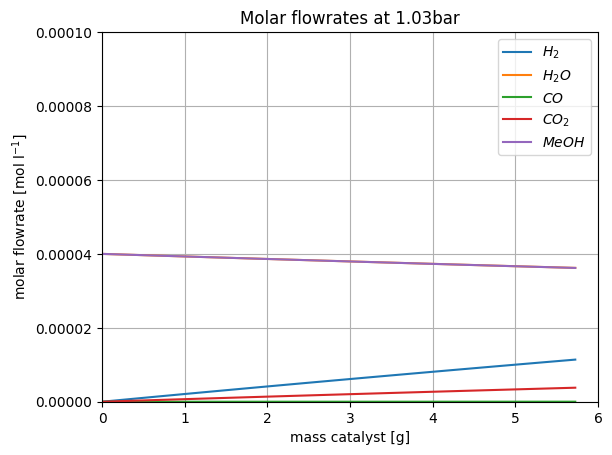

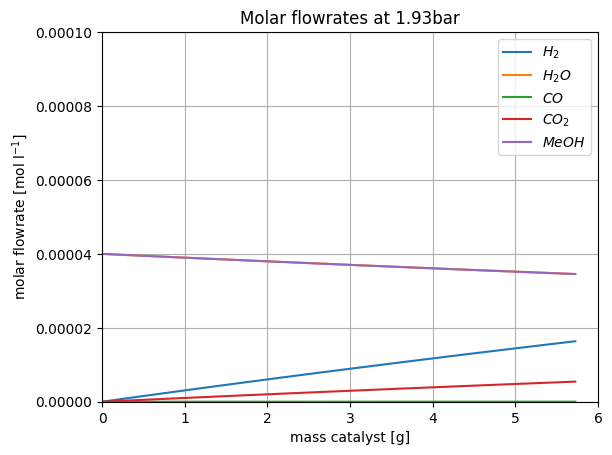

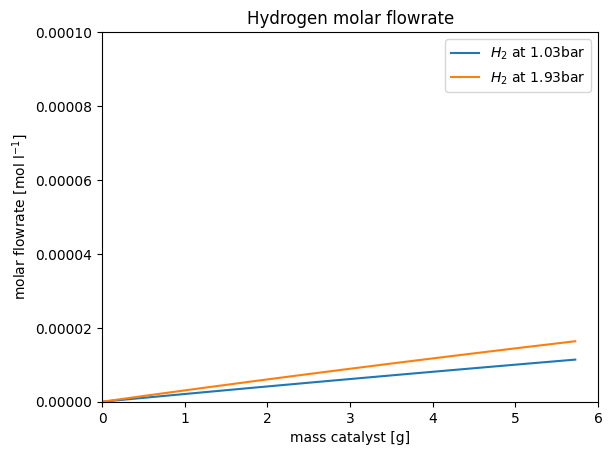

In [ ]:
# @title plots

for i in range (len(restart_72_means_array)):
  plt.figure(i)
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 0], label='$H_2$')
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 1], label='$H_2O$')
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 2], label='$CO$')
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 3], label='$CO_2$')
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 4], label='$MeOH$')
  plt.title('Molar flowrates at ' + str(round(restart_72_means_array[i, 2], 2)) + 'bar')
  plt.axis((0, 6, 0, 0.0001))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("mass catalyst [g]")
  plt.ylabel ("molar flowrate [mol l$^{-1}$]")


for i in range (len(restart_72_means_array)):
  plt.figure(3)
  plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 0], label='$H_2$ at ' + str(round(restart_72_means_array[i, 2], 2)) + 'bar')
  # plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 1], label='$H_2O$')
  # plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 2], label='$CO$')
  # plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 3], label='$CO_2$')
  # plt.plot(compEul_restart_72[0, :, 5]*1000, compEul_restart_72[i, :, 4], label='$MeOH$')
  plt.title('Hydrogen molar flowrate')
  plt.axis((0, 6, 0, 0.0001))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("mass catalyst [g]")
  plt.ylabel ("molar flowrate [mol l$^{-1}$]")

Text(0, 0.5, 'model flowrate [ml min$^{-1}$]')

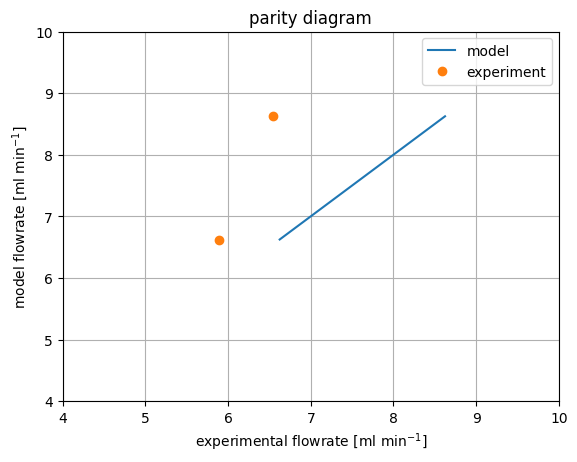

In [ ]:
# @title parity plot flowrates

plt.figure(1)
plt.plot(prodFlow_restart_72_model, prodFlow_restart_72_model, label='model')
plt.plot(restart_72_means_production_flow, prodFlow_restart_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((4, 10, 4, 10))
plt.grid()
plt.xlabel("experimental flowrate [ml min$^{-1}$]")
plt.ylabel ("model flowrate [ml min$^{-1}$]")


Text(0, 0.5, 'model conversion [%]')

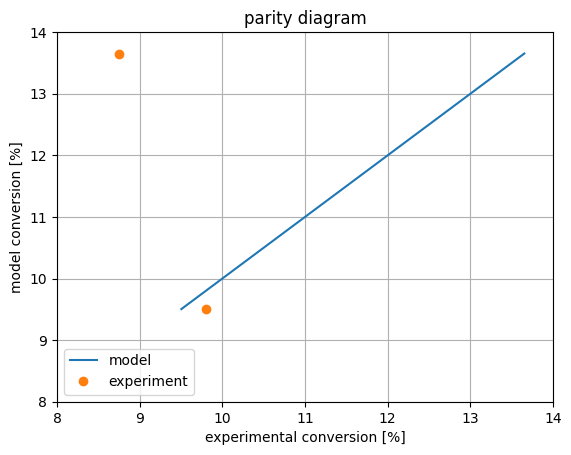

In [ ]:
# @title parity plot conversion

plt.figure(1)
plt.plot(conversion_restart_72_model, conversion_restart_72_model, label='model')
plt.plot(restart_72_means_methanol_conversion, conversion_restart_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((8, 14, 8, 14))
plt.grid()
plt.xlabel("experimental conversion [%]")
plt.ylabel ("model conversion [%]")

# complementary functions || Preliminary

In [ ]:
# @title Temperature ODE

def TempODE ():
  '''
  Temperature ODE
  '''

  dT = 1


  return dT

In [ ]:
# @title dynamic viscosity @400K in microPascals per second

h2 = 10.9
co2 = 20.9
h2o = 13.4
ch3oh = 13

zero_conv = 0.5*h2o + 0.5*ch3oh
full_conv = 0.75*h2 + 0.25*co2
median = (zero_conv+full_conv)/2

print ("dynamic viscosity at zero conversion = " + str(zero_conv))
print ("dynamic viscosity at full conversion = "+ str(full_conv))
print ("median dynamic viscosity = " + str(median))

for i in range (3):
  T = 400+ i*25
  VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))
  print ("volumetric flowrate = " + str(VFlow))

Mh2 = 2.016
Mco2 = 44.01
Mh2o = 18.016
Mch3oh = 32.02

# 1 bar at zero conv, 2 bar at full conversion
M_zero_conv = (0.5*Mh2o + 0.5*Mch3oh)/1000
M_full_conv = (0.75*Mh2 + 0.25*Mco2)/1000

dens_zero_conv = M_zero_conv/R/T*np.power(10, 5, dtype = float)
dens_full_conv = M_full_conv/R/T*2*np.power(10, 5, dtype = float)

print ("gas density at zero conversion = " + str(dens_zero_conv))
print ("gas density at full conversion = " + str(dens_full_conv))

# dens_h2 =
# dens_h2o =
# dens_co2 =
# dens_ch3oh =

dynamic viscosity at zero conversion = 13.2
dynamic viscosity at full conversion = 13.4
median dynamic viscosity = 13.3
volumetric flowrate = 0.27829019872
volumetric flowrate = 0.29568333614
volumetric flowrate = 0.31307647355999996
gas density at zero conversion = 0.6686980461336968
gas density at full conversion = 0.6689920615828722


In [ ]:
Ergun(1, L_R)

(0.24007689997888346, 75992.31000211166)

In [ ]:
# @title experimental data extraction | simple | for now

molar_volume_ideal_gas = 24210 # [ml mol-1]
V_lN_in_default_72 = 0.0023 #[lN h^-1]
n_in_default_72 = 0.08/1000 #[kmol h^-1]
# n_in_default_72_array = [0.00157*60/2/1000, 0.00170*60/2/1000, 0.00165*60/2/1000, 0.00160*60/2/1000, 0.00158*60/2/1000, 0.00152*60/2/1000, 0.00158*60/2/1000]

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/CS_72_02.xlsx'
default_72 = pd.read_excel(filepath, sheet_name ='Ergebnisse', usecols='B:E, G:I', header = 5)
default_72 = default_72.dropna(how='all')
units = default_72.head(1)
default_72 = default_72.drop(0, axis=0)
default_72_cat = pd.read_excel(filepath, sheet_name ='Ergebnisse')
cat_mass_default_72 = default_72_cat.head(2)['Katalysator']
cat_mass_default_72 = cat_mass_default_72[1]/1000
default_72['group']= (default_72['Reactor Temperature'].diff()!= 0).cumsum()
default_72_molar_fraction_base = default_72['COppm'] + default_72['CO2'] + default_72['H2']
default_72['CO Flow'] = default_72['COppm']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['CO2 Flow'] = default_72['CO2']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['H2 Flow'] = default_72['H2']/default_72_molar_fraction_base*default_72['Productgas FlowGasanalyzer']/molar_volume_ideal_gas*60
default_72['H2:CO2 ratio'] = default_72['H2 Flow']/default_72['CO2 Flow']
default_72['X_{MeOH} [%]'] = (1 - ((n_in_default_72/2)*1000-(default_72['CO2 Flow']+default_72['CO Flow']))/((n_in_default_72*1000)/2))*100

criteria = default_72.groupby('group')['group'].transform(lambda x:  np.arange(len(x)) > int(len(x) / 2))
default_72_means = default_72[criteria].groupby('group').mean()
default_72_means['n. MeOH in'] = n_in_default_72/2*1000
default_72_means['n. MeOH in2'] = [0.00157*60/2, 0.00170*60/2, 0.00165*60/2, 0.00160*60/2, 0.00158*60/2, 0.00152*60/2, 0.00158*60/2]
default_72_means['X_{MeOH} [%]2'] = (1 - (default_72_means['n. MeOH in2']-default_72_means['CO2 Flow']-default_72_means['CO Flow'])/default_72_means['n. MeOH in2'])*100

# @title misc calcs

m_cat_default_72_span = np.arange(0, cat_mass_default_72 + cat_mass_default_72/steps, cat_mass_default_72/steps)
default_72_means_array = default_72_means.to_numpy()
dm_cat_mass_default_72 = cat_mass_default_72/steps
compEul_default_72 = np.zeros([len(default_72_means_array), len(m_cat_default_72_span), len(IC)])

prodFlow_default_72_model = np.zeros([len(default_72_means_array)])
H2CO2_ratio_default_72 = np.zeros([len(default_72_means_array)])
conversion_default_72_model = np.zeros([len(default_72_means_array)])

for i in range (len(default_72_means_array)):
  IC_default_72 = np.array([0, n_in_default_72/2, 0, 0, n_in_default_72/2, 0])
  T_72 = default_72_means_array[i, 1] + 273
  p_72 = default_72_means_array[i, 2]
  compEul_default_72 [i, :, :] = MainCalcMolFlow(IC_default_72, T_72, p_72, m_cat_default_72_span, dm_cat_mass_default_72, steps, 0)
  prodFlow_default_72_model [i] = (compEul_default_72 [i, -1, 0] + compEul_default_72 [i, -1, 2] + compEul_default_72 [i, -1, 3]) *R*T_72/p_72/np.power(10, 5, dtype=float)/60*1000*np.power(10, 6, dtype=float)
  H2CO2_ratio_default_72 [i] = compEul_default_72 [i, -1, 0]/compEul_default_72 [i, -1, 3]
  conversion_default_72_model [i] = (1-compEul_default_72 [i, -1, 4]/(n_in_default_72/2))*100

default_72_means_production_flow = default_72_means['Productgas FlowGasanalyzer'].to_numpy()
default_72_means_methanol_conversion = default_72_means['X_{MeOH} [%]2'].to_numpy()

offset_to_experiment_production = (1 - prodFlow_default_72_model/default_72_means_production_flow)*100
offset_to_experiment_conversion = (1 - conversion_default_72_model/default_72_means_methanol_conversion)*100

# print('last results entry in each iteration: ', end='\n\n')
print(compEul_default_72[:, -1, :])
# print(prodFlow_default_72)
# print(H2CO2_ratio_default_72)
# print(dm_cat_mass_default_72)

xx = np.zeros(len(default_72_means_array))
xx = (1-compEul_default_72[:, -1, 4]/compEul_default_72[:, 0, 4])*100
print('Umsatzgrade: ' , xx)

[[1.13990452e-05 3.62069419e-05 9.93539860e-09 3.79305812e-06
  3.61970065e-05 5.72320000e-03]
 [3.39424541e-06 3.88687288e-05 2.15930810e-10 1.13127118e-06
  3.88685129e-05 5.72320000e-03]
 [5.20187583e-06 3.82667993e-05 1.13686126e-09 1.73320070e-06
  3.82656624e-05 5.72320000e-03]
 [7.77109302e-06 3.74120644e-05 3.64308531e-09 2.58793562e-06
  3.74084213e-05 5.72320000e-03]
 [1.12314693e-05 3.62626096e-05 9.64900545e-09 3.73739042e-06
  3.62529606e-05 5.72320000e-03]
 [1.60188333e-05 3.46761311e-05 2.36132301e-08 5.32386894e-06
  3.46525178e-05 5.72320000e-03]
 [1.12229416e-05 3.62654425e-05 9.63452390e-09 3.73455751e-06
  3.62558080e-05 5.72320000e-03]]
Umsatzgrade:  [ 9.50748379  2.82871778  4.33584391  6.47894675  9.36759855 13.36870542
  9.36048009]


In [ ]:
# @title results table

print(units, end='\n\n\n')
# print('mass catalyst used = ' + str(cat_mass_default_72*1000) + 'g', end='\n\n\n')
print(default_72_means)

  Time Reactor Temperature Reactor Pressure COppm  CO2   H2 Productgas FlowGasanalyzer
0    h                  °C           barabs   ppm  ppm  ppm                   ml min-1


          Time  Reactor Temperature  Reactor Pressure       COppm           CO2             H2  Productgas FlowGasanalyzer   CO Flow  CO2 Flow   H2 Flow  H2:CO2 ratio  X_{MeOH} [%]  n. MeOH in  \
group                                                                                                                                                                                              
1       6.2502                150.0          1.033510  225.804759  58805.432783  187926.622198                    8.399757  0.000019  0.004957  0.015841      3.195772     12.439983        0.04   
2      12.7502                120.0          1.030760   19.896372  21333.901768   63517.350587                    2.375622  0.000001  0.001480  0.004406      3.013448      3.704150        0.04   
3      18.7502                130.0     

In [ ]:
# @title printing

print("prodFlow_default_72_model", end="\n")
print(prodFlow_default_72_model, end="\n\n")
print("default_72_means_production_flow", end="\n")
print(default_72_means_production_flow, end="\n\n")
print("conversion_default_72_model", end="\n")
print(conversion_default_72_model, end="\n\n")
print("default_72_means_methanol_conversion", end="\n")
print(default_72_means_methanol_conversion, end="\n\n")
print("offset_to_experiment_production", end="\n")
print(offset_to_experiment_production, end="\n\n")
print("offset_to_experiment_conversion", end="\n")
print(offset_to_experiment_conversion, end="\n\n")

prodFlow_default_72_model
[ 8.62157127  2.39101799  3.76199722  5.77759431  8.71249204 12.72438894
  8.71717585]

default_72_means_production_flow
[8.39975658 2.37562158 3.70673391 5.78004158 8.1197782  9.89930682
 7.15757027]

conversion_default_72_model
[ 9.50748379  2.82871778  4.33584391  6.47894675  9.36759855 13.36870542
  9.36048009]

default_72_means_methanol_conversion
[10.56474119  2.90521532  4.30192633  7.06748519 10.17079317 13.10058489
  9.08693795]

offset_to_experiment_production
[ -2.64072755  -0.6481004   -1.49088952   0.04233994  -7.29963086
 -28.53818118 -21.78959497]

offset_to_experiment_conversion
[10.00741406  2.63311086 -0.7884277   8.32740961  7.8970696  -2.04663015
 -3.0102786 ]



In [ ]:
default_72

,Time,Reactor Temperature,Reactor Pressure,COppm,CO2,H2,Productgas FlowGasanalyzer,group,CO Flow,CO2 Flow,H2 Flow,H2:CO2 ratio,X_{MeOH} [%]
2,0.250195,150,1.049935,0.288645,139.933194,708.762742,0.021792,1,0.0,0.000009,0.000045,5.065008,0.0223
3,0.5002,150,1.051548,0.178903,279.828032,3421.726581,0.095486,1,0.0,0.000018,0.000219,12.227962,0.044751
4,0.7502,150,1.051355,0.23329,280.432065,45875.013065,1.254688,1,0.0,0.000019,0.003091,163.586903,0.047271
5,1.0002,150,1.049484,0.96271,285.989677,109854.375032,3.177335,1,0.0,0.00002,0.007854,384.12007,0.051288
6,1.2502,150,1.049258,4.413484,267.990065,146309.816226,4.402678,1,0.0,0.00002,0.010891,545.95239,0.050693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,42.0002,150,1.006839,145.624097,52686.732968,165510.216452,7.154542,7,0.000012,0.004279,0.013441,3.141402,10.726051
170,42.2502,150,1.005935,144.907613,52586.857516,165381.066258,7.144917,7,0.000012,0.004269,0.013426,3.144913,10.702488
171,42.5002,150,1.006419,143.774129,52492.227387,164940.278516,7.122455,7,0.000012,0.004259,0.013381,3.142185,10.675729
172,42.7502,150,1.006548,142.915935,52526.816032,164654.824839,7.111921,7,0.000012,0.00426,0.013354,3.134681,10.679126


In [ ]:
# @title testing block, ignore

# print(prodFlow_default_72)
# print(default_72_means_production_flow)
# print(offset_to_experiment)

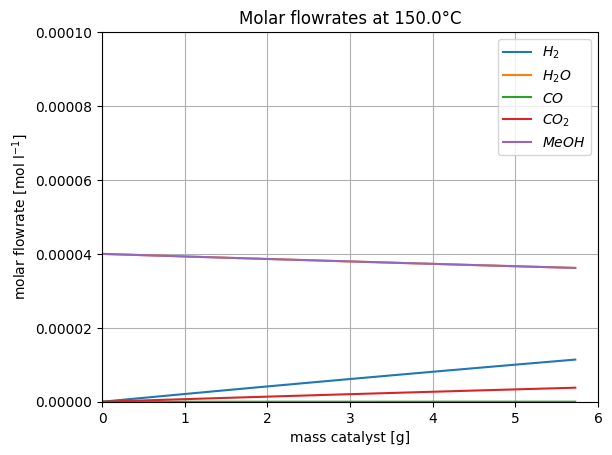

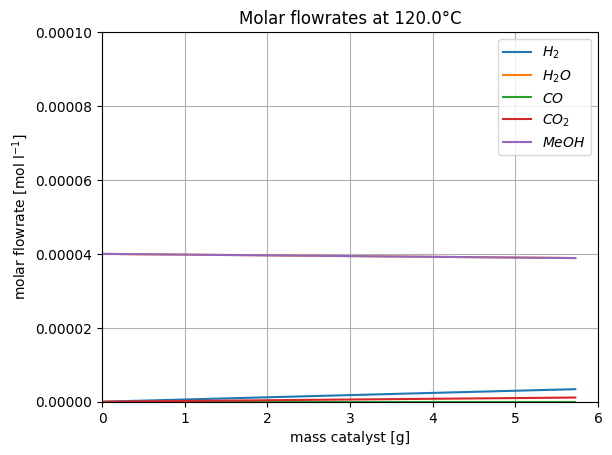

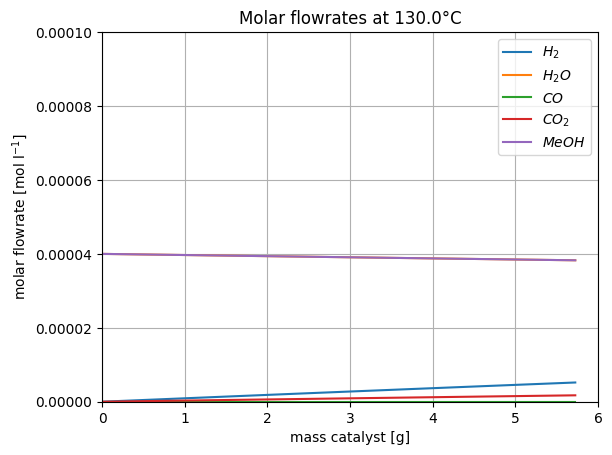

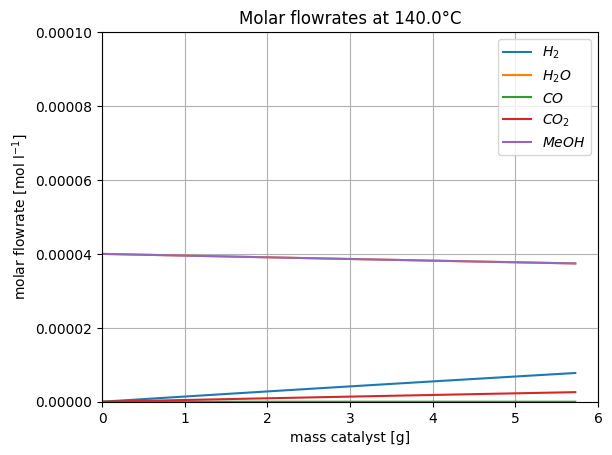

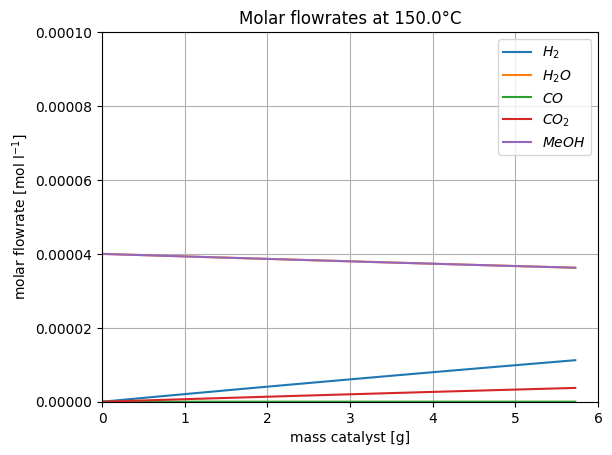

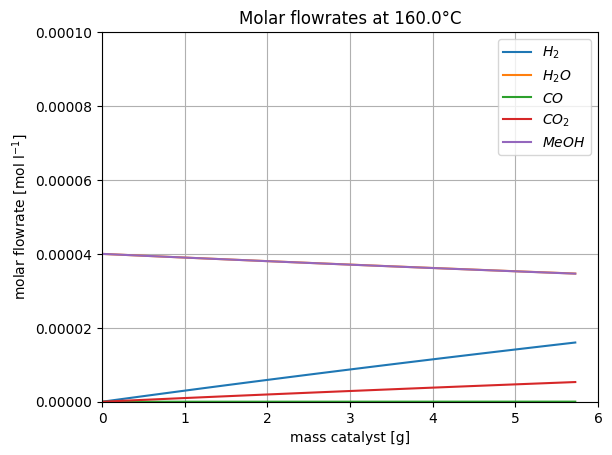

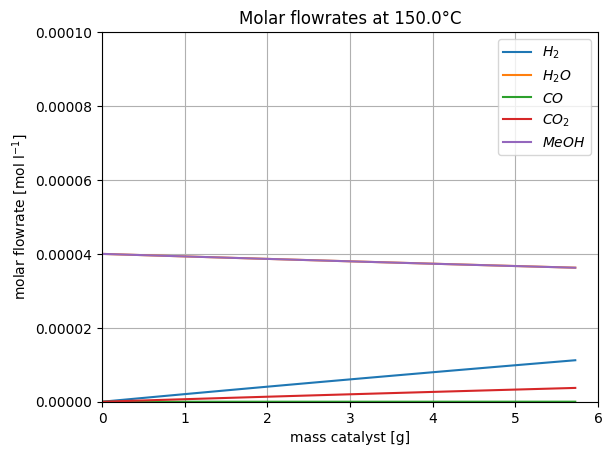

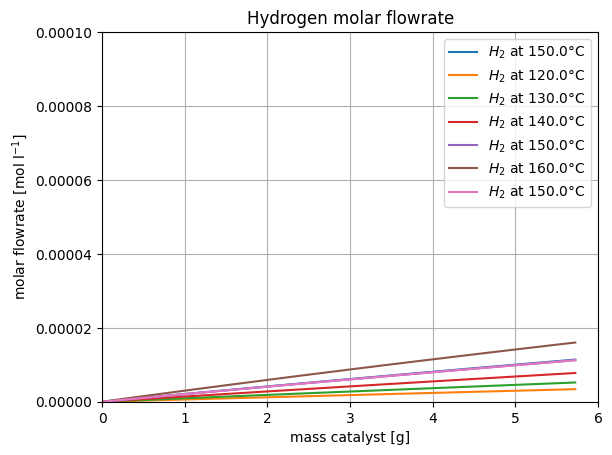

In [ ]:
# @title plots

for i in range (len(default_72_means_array)):
  plt.figure(i)
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 0], label='$H_2$')
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 1], label='$H_2O$')
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 2], label='$CO$')
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 3], label='$CO_2$')
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 4], label='$MeOH$')
  plt.title('Molar flowrates at ' + str(default_72_means_array[i, 1]) + '°C')
  plt.axis((0, 6, 0, 0.0001))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("mass catalyst [g]")
  plt.ylabel ("molar flowrate [mol l$^{-1}$]")


for i in range (len(default_72_means_array)):
  plt.figure(len(default_72_means_array))
  plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 0], label='$H_2$ at ' + str(default_72_means_array[i, 1]) + '°C')
  # plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 1], label='$H_2O$')
  # plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 2], label='$CO$')
  # plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 3], label='$CO_2$')
  # plt.plot(compEul_default_72[0, :, 5]*1000, compEul_default_72[i, :, 4], label='$MeOH$')
  plt.title('Hydrogen molar flowrate')
  plt.axis((0, 6, 0, 0.0001))
  plt.legend(loc='best')
  plt.grid()
  plt.xlabel("mass catalyst [g]")
  plt.ylabel ("molar flowrate [mol l$^{-1}$]")

Text(0, 0.5, 'model flowrate [ml min$^{-1}$]')

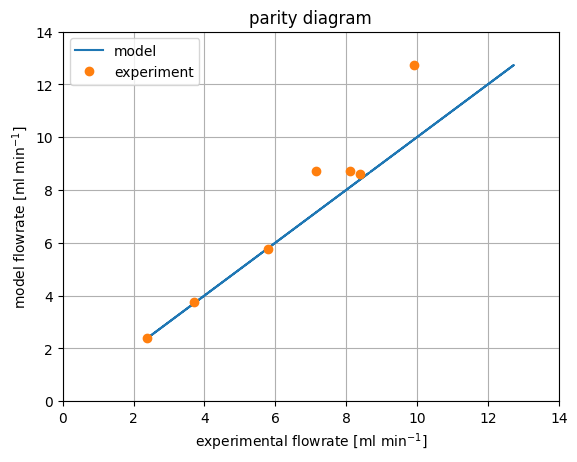

In [ ]:
# @title parity plot flowrates

plt.figure(1)
plt.plot(prodFlow_default_72_model, prodFlow_default_72_model, label='model')
plt.plot(default_72_means_production_flow, prodFlow_default_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((0, 14, 0, 14))
plt.grid()
plt.xlabel("experimental flowrate [ml min$^{-1}$]")
plt.ylabel ("model flowrate [ml min$^{-1}$]")


Text(0, 0.5, 'model conversion [%]')

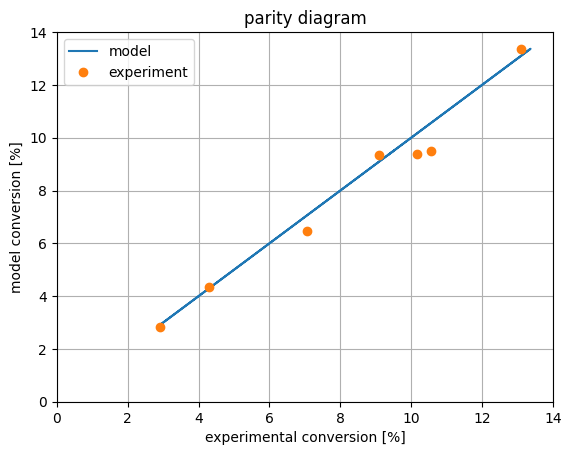

In [ ]:
# @title parity plot conversion

plt.figure(1)
plt.plot(conversion_default_72_model, conversion_default_72_model, label='model')
plt.plot(default_72_means_methanol_conversion, conversion_default_72_model, label='experiment', marker='o', linestyle='')
plt.title('parity diagram')
plt.legend(loc='best')
plt.axis((0, 14, 0, 14))
plt.grid()
plt.xlabel("experimental conversion [%]")
plt.ylabel ("model conversion [%]")

In [ ]:
#old stuff, ausreißer

# default_72['diff'] = default_72['Methanol Flow'].diff().abs()
# default_72.loc[default_72['diff'] > 1*10**-5, 'diff group'] = 1
# default_72.loc[default_72['diff'] < 1*10**-5, 'diff group'] = 0
# default_72 = default_72[default_72['diff group'] == 0]

# default_72['diff2'] = default_72['Methanol Flow'].diff().abs()
# default_72['group'] = (default_72['diff2'] > 2*10**-5).cumsum()
# grouped_default_72 = default_72.groupby(['group'])['H2 Flow'].rolling(5).std()

# default_72_means = default_72.groupby('group').mean()
# default_72_means = default_72_means[['Time', 'Methanol Flow', 'Productgas FlowGasanalyzer', 'CO Flow', 'CO2 Flow', 'H2 Flow']]
# default_72_means